In [1]:
import scripts.model as model
from scripts.config import *

vae = model.VAE()
vae.load(MODEL_NAME, MODEL_DIR)

# vae2 = model.VAE()
# vae2.load("vae_celeba_5", MODEL_DIR)

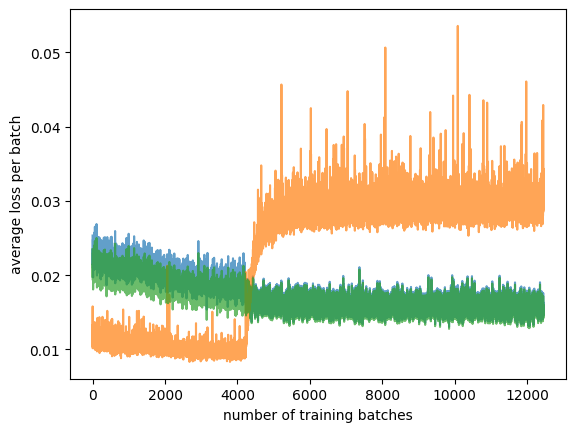

In [2]:
import matplotlib.pyplot as plt
import numpy as np

start_at = 4000

plt.plot(vae.loss_history["loss_total"][start_at:], alpha=0.7)
plt.plot(np.array(vae.loss_history["kld_loss"][start_at:])*0.0001, alpha=0.7)
plt.plot(np.array(vae.loss_history["mse_loss"][start_at:]), alpha=0.7)
# plt.plot(np.array(vae2.loss_history["kld_loss"][start_at:]), alpha=0.7)
plt.xlabel("number of training batches")
plt.ylabel("average loss per batch")
plt.show()

In [92]:
import torch
from scripts import util, dataset

device = util.get_device()
vae = vae.to(device)
vae.eval()

input_size = vae.input_size
input_size[0] = min(4, input_size[0])

train_loader = dataset.get_train_loader(vae.input_size, DATASET_NAME, DATASET_DIR)

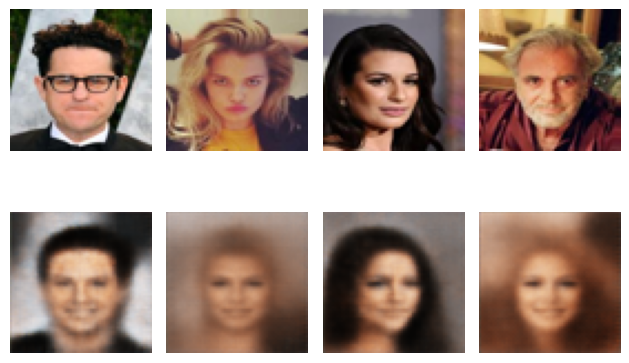

In [4]:
with torch.no_grad():
    batch, _ = next(iter(train_loader))
    recon, _, _, _ = vae(batch.to(device))
    bsub, rsub = batch, recon.cpu()
    util.plot_image_grid(2, len(batch), torch.cat((bsub, rsub)))

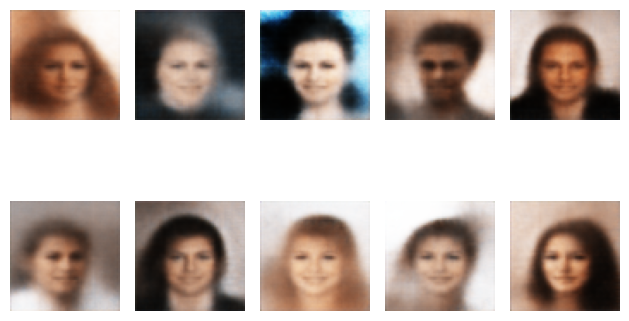

In [90]:
# Random latent samples decoded

with torch.no_grad():
    z = torch.randn(10, LATENT_SIZE).to(device)
    recon = vae.decode(z*3)
    util.plot_image_grid(2, 5, recon.cpu())

tensor(1.0000, device='cuda:0')
torch.Size([4, 1536])
tensor(2., device='cuda:0')


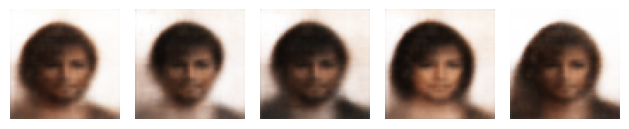

In [80]:
with torch.no_grad():
    t = z[9].view(1, LATENT_SIZE)*3
    recon = vae.decode(t)
    # util.plot_image_grid(1, 1, recon.cpu())

    d = torch.randn((4, LATENT_SIZE))
    d = d / d.norm(dim=1, keepdim=True)
    
    d = d.to(device)

    print(d[0].norm())

    print(d.shape)
    print(d.norm())

    x = t + d*50

    near = vae.decode(x)

    util.plot_image_grid(1, 5, torch.cat((recon.cpu(), near.cpu()), dim=0))


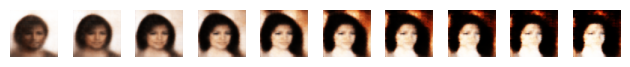

In [ ]:
# Explore the latent space

with torch.no_grad():
    dd = d[2] # desired direction

    it = torch.arange(10, device=device)
    x = t + 50*it[:, None]*dd[None, :]

    path = vae.decode(x)
    util.plot_image_grid(1, 10, path.cpu())

In [100]:
# Get latent space representation
latents = []
labels = []

train_iter = iter(train_loader)

with torch.no_grad():
    for i in range(256):
        images, label = next(train_iter)
        images = images.to(device)
        recon, z, z_mean, z_log_var = vae(images)
        latents.append(z_mean)
        labels.append(label)

latents = torch.cat(latents).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()
print(latents.shape)
print(labels.shape)

(1024, 1536)
(1024, 40)


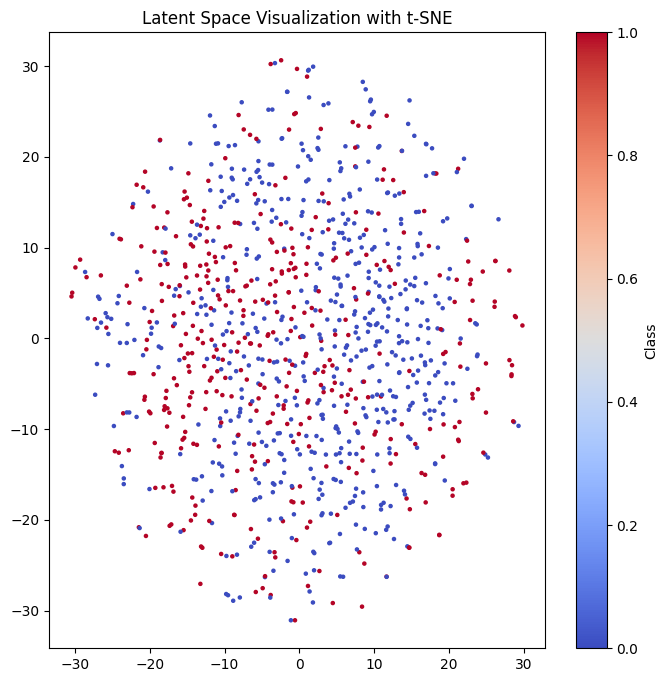

In [101]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE on latent vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d_tsne = tsne.fit_transform(latents)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))

scatter = plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=labels[:, 20], cmap='coolwarm', s=5)

plt.colorbar(scatter, label="Class")
plt.title("Latent Space Visualization with t-SNE")
plt.show()

(1024, 1536)


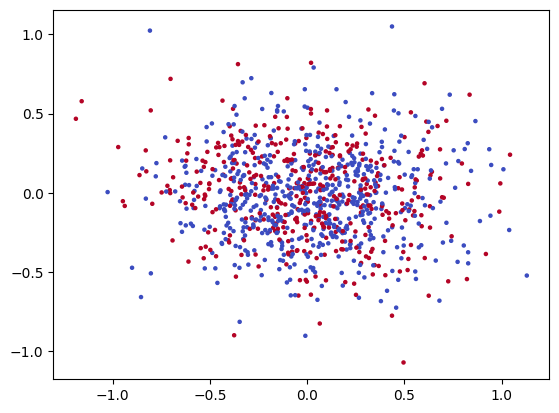

In [102]:
# plot a 2d slice out of Nd latent space (for 2d latent it's a perfect representation)
print(latents.shape)
plt.scatter(latents[:,0], latents[:,1], c=labels[:,20], cmap='coolwarm', s=5)
plt.show()